# Intersection with a crosswalk

**Load dependencies**

In [1]:
rng = MersenneTwister(1);

In [2]:
using POMDPs, POMDPToolbox, DiscreteValueIteration, MDPModelChecking
using StaticArrays
using DeepRL, TensorFlow, DeepQLearning
using AutomotiveDrivingModels, AutomotivePOMDPs
using AutomotiveSensors
using LocalApproximationValueIteration
using Reel, AutoViz
using ProgressMeter
using JLD
using PedCar

In [3]:
include("masking.jl")
include("util.jl")
include("render_helpers.jl")

In [4]:
cam = FitToContentCamera(0.);

## Scenario

In [5]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

## Discrete MDP

In [6]:
mdp = PedCarMDP(env=env, pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7);
init_transition!(mdp);

In [7]:
@printf("spatial resolution %2.1f m \n", mdp.pos_res)
@printf("pedestrian velocity resolution %2.1f m/s \n", mdp.vel_ped_res)
@printf("car velocity resolution %2.1f m/s \n", mdp.vel_res)
@printf("number of states %d \n", n_states(mdp))
@printf("number of actions %d \n", n_actions(mdp))

spatial resolution 2.0 m 
pedestrian velocity resolution 1.0 m/s 
car velocity resolution 2.0 m/s 
number of states 23456940 
number of actions 4 


In [9]:
vi_data = load("pc_processed.jld")
policy = ValueIterationPolicy(mdp, vi_data["qmat"], vi_data["util"], vi_data["pol"]);

In [8]:
# Load VI data for maksing
state_space = states(mdp);
vi_data = load("pc_util_inter.jld")
@showprogress for s in state_space
    if !s.crash && isterminal(mdp, s)
        si = state_index(mdp, s)
        vi_data["util"][si] = 1.0
        vi_data["qmat"][si, :] = ones(n_actions(mdp))
    end
end
policy = ValueIterationPolicy(mdp, vi_data["qmat"], vi_data["util"], vi_data["pol"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:2739m


In [9]:
JLD.save("pc_processed.jld", "util", policy.util, "qmat", policy.qmat, "pol", policy.policy);

In [10]:
threshold = 0.999
mask = SafetyMask(mdp, policy, threshold);

In [11]:
rand_pol = MaskedEpsGreedyPolicy(mdp, 1.0, mask, rng);
# rand_pol = solve(RandomSolver(), mdp);

In [12]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initial_state(mdp, rng)
@time hist2 = simulate(hr, mdp, policy, s0);

  1.496290 seconds (729.72 k allocations: 37.477 MiB, 12.98% gc time)


In [13]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, UrbanAction(NaN))
duration, fps, render_hist = animate_states(mdp, state_hist, action_hist, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpMSEJlo", 0x0000000000000029, 2.0, nothing)

In [155]:
@showprogress for ep=1:10000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initial_state(mdp, rng)
    hist2 = simulate(hr, mdp, rand_pol, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

Progress:   4%|██                                       |  ETA: 0:21:50

Crash


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


**Evaluation**

In [109]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(mdp, rand_pol, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

 54.938390 seconds (198.61 M allocations: 21.097 GiB, 13.90% gc time)
Summary for 10000 episodes: 
Average reward: 0.043 
Average # of steps: 78.269 
Average # of violations: 0.100 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


## Continuous state MDP

In [14]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

In [15]:
pomdp = UrbanPOMDP(env=env,
                   ego_goal = LaneTag(2, 1),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.7, 
                   ped_birth=0.7, 
                   obstacles=false, # no fixed obstacles
                   lidar=false,
                   pos_obs_noise = 0., # fully observable
                   vel_obs_noise = 0.,
                   ego_start=20,
                   ΔT=0.5);

In [16]:
function POMDPToolbox.generate_sori(pomdp::UrbanPOMDP, s::Scene, a::UrbanAction, rng::AbstractRNG)
    sp, o, r = generate_sor(pomdp, s, a, rng)
    return sp, o, r, deepcopy(pomdp.models)
end

In [17]:
rand_pol = RandomMaskedPOMDPPolicy(mask, pomdp, rng);
# rand_pol = solve(RandomSolver(), mdp);

In [18]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initial_state(pomdp,rng)
o0 = generate_o(pomdp, s0, rng)
up = FastPreviousObservationUpdater{UrbanObs}()
b0 = initialize_belief(up, o0)
@time hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0);

  1.902798 seconds (5.78 M allocations: 237.774 MiB, 6.70% gc time)


In [19]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
belief_hist = h.belief_hist
safe_acts = [i[1] for i in h.ainfo_hist]
probas = [i[2] for i in h.ainfo_hist]
routes = [i[3] for i in h.ainfo_hist]

push!(safe_acts, [UrbanAction(NaN)])
push!(probas, [NaN])
push!(routes, PedCar.OFF_ROUTE)
push!(action_hist, UrbanAction(NaN))
duration, fps, render_hist = animate_states(pomdp, state_hist, action_hist, belief_hist, safe_acts, probas, routes, mask, interp=true, obsviz=true)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpgZcfyf", 0x0000000000000065, 2.0, nothing)

In [22]:
include("masking.jl")
include("render_helpers.jl")

In [66]:
fieldnames(LaneTag)

2-element Array{Symbol,1}:
 :segment
 :lane   

In [99]:
s = h.state_hist[2]
b = h.belief_hist[2]
ai = h.ainfo_hist[2]
a = h.action_hist[2]
# println(ai[1])
# println(ai[2])
# println(a)
# println(safe_actions(pomdp, rand_pol.mask, s, 101, 2))
# println(safe_actions(pomdp, rand_pol.mask, b))
action(rand_pol, b)
# for veh in s
#     println(veh)
# end
s_mdp = get_mdp_state(rand_pol.mask.mdp, rand_pol.pomdp, s, PED_ID, CAR_ID)
itp_ped, itp_ped_w = interpolate_pedestrian(mdp, s_mdp.ped)
for ped in itp_ped
    println(ped)
end
println(s_mdp.ped)

VehicleState(VecSE2({-7.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.000000}, {19, 1}), 0.000, 0.000, 0.000), 1.000)
VehicleState(VecSE2({-5.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.142857}, {19, 1}), 2.000, 0.000, 0.000), 1.000)
VehicleState(VecSE2({-6.079, -5.423}, 0.000), Frenet(RoadIndex({1, 0.065755}, {19, 1}), 0.921, -0.423, 0.000), 1.000)


In [78]:
s_mdp.ped

VehicleState(VecSE2({-28.000, -29.100}, 0.000), Frenet(RoadIndex({1, 0.000000}, {18, 1}), 0.000, 22.000, -1.571), 0.000)

In [68]:
model = h.info_hist[57][2]
model.a


LoadError: [91mBoundsError: attempt to access 44-element Array{Any,1} at index [57][39m

In [64]:
[m.a for m in model.crosswalk_drivers]
m = model.intersection_driver
m.priority

true

In [61]:
AutomotivePOMDPs.engaged(m, state_hist[57], env.roadway, 2)

true

In [63]:
# AutomotivePOMDPs.engaged(model, state_hist[25], env.roadway, 2)
observe!(model, state_hist[25], env.roadway, 2)

AutomotivePOMDPs.UrbanDriver
  a: AutomotivePOMDPs.LonAccelDirection
  navigator: AutomotivePOMDPs.RouteFollowingIDM
  intersection_driver: AutomotivePOMDPs.TTCIntersectionDriver
  crosswalk_drivers: Array{AutomotivePOMDPs.CrosswalkDriver}((3,))
  debug: Bool false


In [198]:
sc = state_hist[1]
b = h.belief_hist[1]
safe_actions(pomdp, mask, sc, 101, 2)

4-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-4.0)
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [24]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:03m

13856.646990 seconds (39.01 G allocations: 1.467 TiB, 6.75% gc time)
Summary for 

Progress: 100%|█████████████████████████████████████████| Time: 3:50:56


10000 episodes: 
Average reward: 0.037 
Average # of steps: 76.584 
Average # of violations: 2.460 


In [146]:
@showprogress for ep=1:10000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initial_state(pomdp, rng)
    o0 = generate_o(pomdp, s0, rng)
    up = FastPreviousObservationUpdater{UrbanObs}()
    b0 = initialize_belief(up, o0)
    hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

Progress:  66%|███████████████████████████              |  ETA: 0:29:44

Crash


Progress: 100%|█████████████████████████████████████████| Time: 0:56:44


## Trained Policy

In [31]:
include("masked_dqn.jl")

In [32]:
problem_file="joint-log/log7/problem.jld"
weights_file="joint-log/log7/weights.jld"
solver = jldopen(problem_file, "r") do file
    read(file, "solver")
end
env_ = POMDPEnvironment(pomdp)
graph = TensorFlow.Graph()
train_graph = DeepQLearning.build_graph(solver, env_, graph)
policy = DeepQLearning.restore_policy(env_, solver, train_graph, weights_file);

2018-08-15 22:53:24.381770: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [43]:
masked_policy = MaskedDQNPolicy(pomdp, policy, mask);

In [44]:
function POMDPToolbox.action_info(policy::MaskedDQNPolicy, s)
    return action(policy, s), safe_actions(policy.problem, policy.mask, s)
end

In [51]:
hr = HistoryRecorder(rng=rng, max_steps=400)
s0 = initial_state(pomdp,rng)
o0 = generate_o(pomdp, s0, rng)
up = FastPreviousObservationUpdater{UrbanObs}()
b0 = initialize_belief(up, o0)
@time hist2 = simulate(hr, pomdp, masked_policy, up, b0, s0);

  0.576406 seconds (3.49 M allocations: 135.416 MiB, 13.96% gc time)


In [52]:
include("render_helpers.jl")

In [53]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
safe_acts = h.ainfo_hist
push!(action_hist, UrbanAction(NaN))
push!(safe_acts, [UrbanAction(NaN)])
duration, fps, render_hist = animate_states(pomdp, state_hist, action_hist, safe_acts, mask, interp=false)
speed_factor = 2
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpMXnikW", 0x000000000000007e, 20.0, nothing)

In [85]:
function MDPModelChecking.safe_actions(pomdp::UrbanPOMDP, mask::SafetyMask{PedCarMDP, P}, s::UrbanState, ped_id, car_id) where P <: Policy
    s_mdp = get_mdp_state(mask.mdp, pomdp, s, ped_id, car_id)
    itp_states, itp_weights = interpolate_state(mask.mdp, s_mdp)
    action_space = actions(mask.mdp)
    # compute risk vector
    p_sa = zeros(n_actions(mask.mdp))
    for (i, ss) in enumerate(itp_states)
        vals = value_vector(mask.policy, ss)
        p_sa += itp_weights[i]*vals
    end
#     println(p_sa)
    safe_acts = UrbanAction[]
    sizehint!(safe_acts, n_actions(mask.mdp))
    if maximum(p_sa) <= mask.threshold
        push!(safe_acts, action_space[indmax(p_sa)])
    else
        for (j, a) in enumerate(action_space)
            if p_sa[j] > mask.threshold
                push!(safe_acts, a)
            end
        end
    end
    return safe_acts
end

safe_actions(pomdp, mask, state_hist[1], 101, 2)

4-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-4.0)
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [38]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, masked_policy, n_ep=1000, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:01

551.768113 seconds (3.30 G allocations: 126.089 GiB, 15.24% gc time)
Summary for 1000 episodes: 
Average reward: 0.019 
Average # of steps: 114.100 
Average # of violations: 0.100 


Progress: 100%|█████████████████████████████████████████| Time: 0:09:12


## Local Approximation VI

In [9]:
using NearestNeighbors, LocalApproximationValueIteration, LocalFunctionApproximation, StaticArrays
data = JLD.load("lavi_10neighb100k.jld")
function convert_states(mdp::PedCarMDP, sampled_states::Vector{Int64})
    n_routes = 4
    n_features = 4
    nd = n_features*3 + n_routes + 1
    points = Vector{SVector{nd, Float64}}(length(sampled_states))
    for (i, si) in enumerate(sampled_states)
        s = ind2state(mdp, si)
        z = convert_s(Vector{Float64}, s, mdp)
        points[i] = SVector{nd, Float64}(z...)
    end
    return points
end
function set_terminal_costs!(mdp::PedCarMDP, knnfa::LocalNNFunctionApproximator)
    for (i, pt) in enumerate(knnfa.nnpoints)
        s = convert_s(PedCarMDPState, pt, mdp)
        if !s.crash && isterminal(mdp, s) 
            knnfa.nnvalues[i] = 1.0
        elseif s.crash 
            knnfa.nnvalues[i] = 0.0
        end
    end
end
sampled_states = data["sampled_states"]
points = convert_states(mdp, sampled_states)
nntree = KDTree(points)
k = 10
knnfa = LocalNNFunctionApproximator(nntree, points, k)
set_all_interpolating_values(knnfa, data["values"])
solver = LocalApproximationValueIterationSolver(knnfa)
policy = LocalApproximationValueIterationPolicy(mdp, solver);
set_terminal_costs!(mdp, policy.interp);

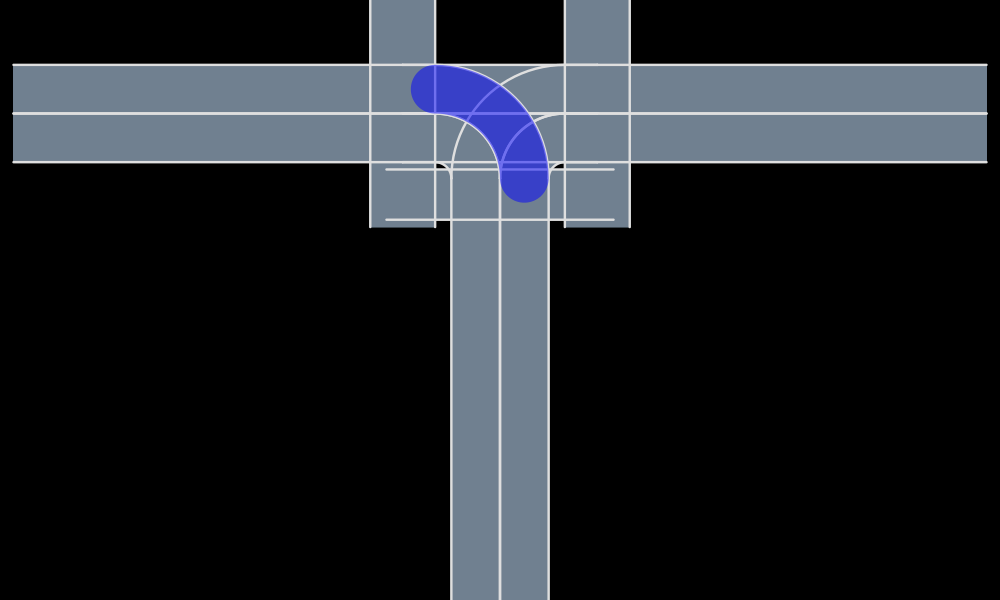

In [52]:
scene = Scene()
roadway = env.roadway
type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end
i = 13
render(scene, roadway, [LaneOverlay(roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=cam)

In [7]:
@time state_space = states(mdp);

 70.573907 seconds (547.74 M allocations: 16.653 GiB, 12.76% gc time)


In [8]:
@assert n_states(mdp) == length(state_space)

In [9]:
@showprogress for (i, s) in enumerate(state_space)
    if i != state_index(mdp, s)
        println(i)
        println(s)
        break
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:1939m


In [10]:
struct StopPolicy <: Policy
end
function POMDPs.action(policy::StopPolicy, s)
    return UrbanAction(0.)
end

In [12]:
rand_pol = solve(RandomSolver(), mdp)
# rng = MersenneTwister(2)

hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initial_state(mdp, rng)
@time hist2 = simulate(hr, mdp, rand_pol, s0);
n_steps(hist2)

  0.032352 seconds (502.77 k allocations: 17.335 MiB)


100

In [13]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, UrbanAction(NaN))
duration, fps, render_hist = AutomotivePOMDPs.animate_states(mdp, state_hist, action_hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpVdQmgP", 0x0000000000000065, 2.0, nothing)

In [14]:
function AutomotivePOMDPs.animate_states(mdp::Union{PedCarMDP,CarMDP,PedMDP}, 
                                         states::Union{Vector{CarMDP}, Vector{PedMDP}, Vector{PedCarMDPState}},
                                         actions::Vector{UrbanAction};
                        overlays=SceneOverlay[IDOverlay()],
                        cam=StaticCamera(VecE2(0, -5.), 17.))
    duration = length(states)*mdp.ΔT
    fps = Int(1/mdp.ΔT)    
    function render_states(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        scene = state2scene(mdp, states[frame_index])
        return AutoViz.render(scene,
                mdp.env,
              cat(1, overlays,   TextOverlay(text = ["v: $(get_ego(scene).state.v)"],
                                            font_size=20,
                                            pos=VecE2(mdp.env.params.x_min + 3.,6.),
                                            incameraframe=true),
                                 TextOverlay(text = ["Acc: $(actions[frame_index].acc)"],
                                            font_size=20,
                                            pos=VecE2(mdp.env.params.x_min + 3.,8.),
                                            incameraframe=true),
                                TextOverlay(text = ["step: $frame_index"],
                                            font_size=20,
                                            pos=VecE2(mdp.env.params.x_min + 3.,4.),
                                            incameraframe=true)),
                cam=cam,
                car_colors=get_colors(scene))
    end
    return duration, fps, render_states
end

## Profile Code

In [7]:
using ProfileView
using Traceur

In [8]:
@time state_space = states(mdp);
action_space = actions(mdp)

108.449606 seconds (2.02 G allocations: 59.667 GiB, 12.00% gc time)


4-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-4.0)
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [9]:
Profile.clear()

In [9]:
rng = MersenneTwister(3)
@time for i=1:10000
    s = rand(rng, state_space)
    d = transition(mdp, s, rand(rng, action_space))
end# 2e-3s

  8.823880 seconds (74.61 M allocations: 2.669 GiB, 7.30% gc time)


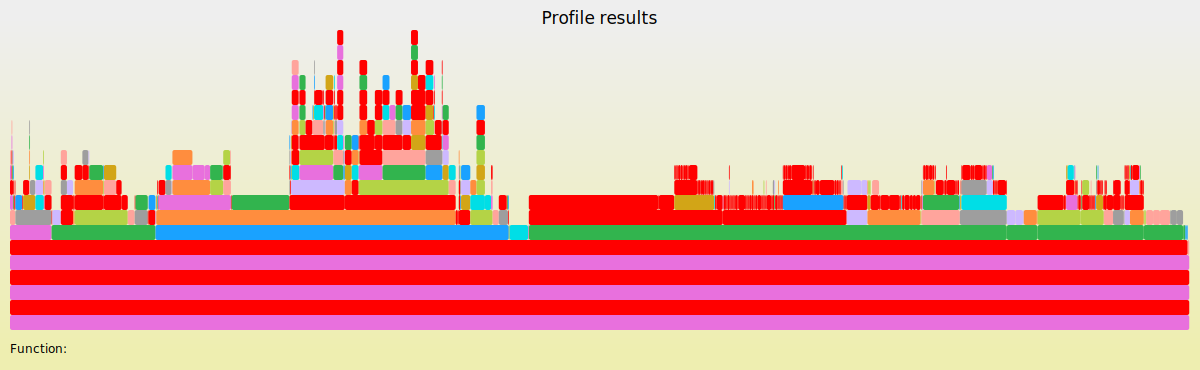

In [63]:
ProfileView.view()

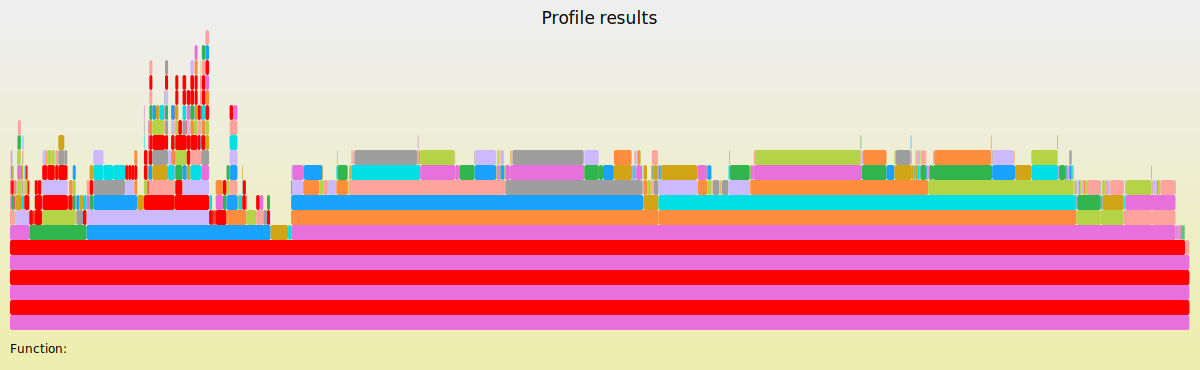

In [14]:
ProfileView.view()

In [59]:
fieldnames(LineSegment)

2-element Array{Symbol,1}:
 :A
 :B

In [60]:
methods(LineSegment)

# 3 methods for generic function "(::Type)":
Vec.LineSegment(A::Vec.VecE2, B::Vec.VecE2) in Vec at /mnt/c/Users/Maxime/wsl/.julia/v0.6/Vec/src/geom/line_segments.jl:6
Vec.LineSegment(A, B) in Vec at /mnt/c/Users/Maxime/wsl/.julia/v0.6/Vec/src/geom/line_segments.jl:6
(::Type{T})(arg) where T in Base at sysimg.jl:77

In [45]:
l = env.roadway[LaneTag(1,1)]
l.curve

2-element Array{AutomotiveDrivingModels.CurvePt,1}:
 CurvePt({30.000, 1.500, 3.142}, 0.000, NaN, NaN)
 CurvePt({6.000, 1.500, 3.142}, 24.000, NaN, NaN)

In [ ]:
@trace get_distance_to_crosswalk(mdp.car_model.crosswalk_drivers[1], state2scene(mdp, s))

In [22]:
posg = VecSE2(20., 6., float(pi))
l = mdp.env.roadway[LaneTag(1,1)]
@profile for i=1:1000; Frenet(posg, l, mdp.env.roadway); end

In [40]:
s = rand(rng, state_space);